In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from googletrans import Translator

from datetime import datetime, timezone, timedelta

In [40]:
data = pd.read_csv("data/processed_dialog_files/general_dialogs_df.csv")



5

In [91]:
# TODO: Move these functions to utils/ 

def get_ua_tonality_dict(dict_path="dicts/tone-dict-ua.csv"):
    """
    Read dictionary of ukrainian words tonality and
    return is a a python dict
    """
    sentiment_data = pd.read_csv(dict_path)
    sentiment_dict = dict(zip(sentiment_data.iloc[:, 1], sentiment_data.iloc[:, 3]))

    return sentiment_dict 

def get_ru_tonality_dict(dict_path="dicts/tone-dict-ru.csv"):
    """
    Read dictionary of russian words tonality and
    return is a a python dict
    """
    sentiment_data = pd.read_csv(dict_path, sep=";")
    sentiment_dict = dict(zip(sentiment_data.iloc[:, 0], sentiment_data.iloc[:, 2]))
    
    return sentiment_dict 


def get_day_and_hour(date):
    """
    Parse date string, 
    return hour and day of a week
    """
    date = datetime.fromisoformat(date)
    
    return {'hour': date.hour, 'day': date.isoweekday()}

# __________________________________


tonality_dict_ua = get_ua_tonality_dict()
tonality_dict_ru = get_ru_tonality_dict()


def calculate_msg_sentiment(msg, lang):
    """
    Calculate dictionary-base sentiment of a particular message.
    Return average sentiment of a message.
    
    Works for en, ua, ru
    """
    if not isinstance(msg, str):
        return 0
    
    if lang == "en":     
        return round(TextBlob(msg).sentiment.polarity, 4)
    elif lang == "ua":
        tonality_dict = tonality_dict_ua
    elif lang == "ru":
        tonality_dict = tonality_dict_ru
           
    tokenized_msg = msg.split()  
    overall_sentiment = 0
    words_num = 0
    
    for token in tokenized_msg:             
        token_sentiment = tonality_dict.get(token.lower(), 0)
        if token_sentiment:
            overall_sentiment += token_sentiment
            words_num += 1
    
    if not words_num:
        return 0
    
    avg_sentiment = overall_sentiment / words_num
    
    return avg_sentiment



def add_dialog_sentiment(data):
    """
    Add sentiment for each message in a dialog,
    and add it in a new column for a particular message,
    return new dataframe
    
    Supported languages: eng, ru, ua
    """
    data['msg_sentiment'] = data.apply(lambda x: calculate_msg_sentiment(x['preprocessed_message'], 
                                                                         x['dialog_language']), 
                                       axis=1)
    
    return data


# Save dataframe with sentiment as a physical file :

# result_path="data/processed_dialog_files/general_dialogs_sentiment.csv"
# add_dialog_sentiment(data).to_csv(result_path, index=False)
    

def calculate_avg_subdialog_sentiment(data):
    """
    Calculate average sentiment for each subdialog in a dataframe,
    save results in a dictionary in form of:
    
    {*USER_ID* : {*DIALOG_ID* : {*SUBDIALOG_ID* : *AVG_SENTIMENT*, ... }, ... }, ... }
    
    Return dict
    """
    avg_sentiment_dict = {}
    
    for index, row in data.iterrows():

        sender_id = row['from_id']
        dialog_id = row['dialog ID']
        subdialog_id = row['subdialog_id']
        
        if not sender_id in avg_sentiment_dict:
            avg_sentiment_dict[sender_id] = {}
        if not dialog_id in avg_sentiment_dict[sender_id]:
            avg_sentiment_dict[sender_id][dialog_id] = {}
        if not subdialog_id in avg_sentiment_dict[sender_id][dialog_id]:
            avg_sentiment_dict[sender_id][dialog_id][subdialog_id] = set()
            
        avg_sentiment_dict[sender_id][dialog_id][subdialog_id].add(row['msg_sentiment'])
    
    for sender_id, sentiment_dict in avg_sentiment_dict.items():      
        for dialog_id, subdialog_dict in sentiment_dict.items():
            for subdialog_id, sentiment_set in subdialog_dict.items():
            
                avg_sentiment = round(sum(sentiment_set) / len(sentiment_set), 3)            
                avg_sentiment_dict[sender_id][dialog_id][subdialog_id] = avg_sentiment
            
    return avg_sentiment_dict

        



{'hour': 14, 'day': 1}
{138918380: {0: {1: 0.213, 2: 0.278, 3: 0.318, 4: 0.287, 5: 0.465, 6: 0.0, 7: 0.284, 8: 0.415, 9: 0.133, 10: 0.315, 11: 0.212, 12: 0.226, 13: -0.029, 14: 0.0, 15: 0.0, 16: 0.263, 17: -0.05, 18: 0.205, 19: 0.465, 20: 0.474, 21: 0.377, 22: 0.35, 23: 0.534, 24: 0.246, 25: 0.36, 26: 0.031, 27: 0.177, 28: 0.37, 29: 0.0, 30: 0.258, 31: 0.186, 32: 0.055, 33: 0.271, 34: 0.0, 35: -0.001}}, 511986933: {0: {1: 0.257, 2: -0.046, 3: 0.373, 4: 0.955, 5: 0.39, 6: 0.416, 7: 0.0, 8: 0.282, 9: 0.318, 10: 0.0, 11: 0.378, 12: 0.189, 13: 0.0, 15: 0.0, 16: 0.387, 17: 0.0, 18: 0.134, 19: 0.312, 20: 0.34, 21: 0.198, 22: 0.304, 23: 0.412, 24: 0.389, 25: 0.39, 26: 0.012, 27: 0.311, 28: 0.451, 29: 0.24, 30: 0.201, 31: 0.108, 32: 0.08, 33: 0.468, 34: 0.0, 35: 0.186}, 1: {1: 0.34, 2: 0.414, 3: 0.188, 4: 0.346, 5: 0.0, 6: 0.258, 7: 0.0, 8: 0.276, 9: 0.286, 10: 0.028, 11: 0.295, 12: 0.102, 13: 0.368, 14: 0.012, 15: 0.214, 16: 0.293, 17: 0.282, 18: 0.342, 19: 0.392, 20: 0.033, 21: 0.162, 22: 0.

In [99]:

def calculate_sentiment_by_hour_and_day(data, avg_sentiment_dict):
    """
    Calculate sentiment by day of the week and hour
    for each user.
    
    Sentiment for a particular message is the average sentiment
    for a message in a particular dialog and subdialog (data from 
    avg_sentiment_dict)
     
    Return dict with data ready for visualization
    """
    sentiment_by_time = {}
    
    for index, row in data.iterrows():
     
        msg_date_data = get_day_and_hour(row['date'])
        
        sender_id = row['from_id']
        day_of_week = msg_date_data['day']
        hour = msg_date_data['hour']
               
        dialog_id = row['dialog ID']
        subdialog_id = row['subdialog_id']
        sentiment = avg_sentiment_dict[sender_id][dialog_id][subdialog_id]
    
        if not sender_id in sentiment_by_time:
            sentiment_by_time[sender_id] = {}
        if not day_of_week in sentiment_by_time[sender_id]:
            sentiment_by_time[sender_id][day_of_week] = {hr : set() for hr in range(24)}
            
        sentiment_by_time[sender_id][day_of_week][hour].add(sentiment)
        
    for sender_id, sentiment_timeline_dict in sentiment_by_time.items():
        for day_of_week, hour_data in sentiment_timeline_dict.items():
            for hour in hour_data:
                try:
                    hour_data[hour] = round(sum(hour_data[hour]) / len(hour_data[hour]), 3)
                except ZeroDivisionError:
                    hour_data[hour] = 0
                    
    return sentiment_by_time


sent_data = add_dialog_sentiment(data) 
avg_sent = calculate_avg_subdialog_sentiment(sent_data)
sentiment_data_by_hours = calculate_sentiment_by_hour_and_day(data, avg_sent)

print(sentiment_data_by_hours)

{138918380: {1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0.278, 14: 0.106, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0.177, 22: 0, 23: 0}, 7: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.315, 7: 0, 8: 0, 9: 0.186, 10: 0.35, 11: 0, 12: 0.247, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0.173, 18: 0.133, 19: 0, 20: 0.177, 21: 0, 22: 0, 23: 0}, 6: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.474, 7: 0, 8: 0.37, 9: 0.37, 10: 0.422, 11: 0.422, 12: 0.396, 13: 0.343, 14: 0.213, 15: 0.213, 16: 0.213, 17: 0.213, 18: 0.534, 19: 0.213, 20: 0.295, 21: 0.291, 22: 0, 23: 0}, 5: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: -0.015, 6: 0.534, 7: 0.373, 8: 0.213, 9: 0.235, 10: 0, 11: 0.213, 12: 0.271, 13: 0.213, 14: 0.213, 15: 0.287, 16: 0.066, 17: 0.0, 18: 0.213, 19: 0.474, 20: 0, 21: 0, 22: 0, 23: 0}, 4: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0.0, 9: 0.213, 10: 0.465, 11: 0, 12: 0.212, 13: 0.229, 14: 0.465, 15: 0.339, 16: 0, 17: 0, 18: 0.339, 19: 0.465, 20: 0, 21: 0.26

In [101]:
def visualize_user_sentiment(sentiment_data, user_id):
    """
    Visualize sentiment data for a specific user
    in a timeline (linear graph), starting at 00:00 on Monday,
    finishing at 23:59 on Sunday
    """
    print(sentiment_data[user_id])
    
    
visualize_user_sentiment(sentiment_data_by_hours, 511986933)

{1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0.221, 8: 0.414, 9: 0, 10: 0, 11: 0.248, 12: 0.378, 13: 0.34, 14: 0.298, 15: 0.271, 16: 0.416, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0.518, 22: 0, 23: 0}, 7: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.189, 7: 0.094, 8: 0.26, 9: 0, 10: 0.358, 11: 0.113, 12: 0.305, 13: 0, 14: 0.138, 15: 0.239, 16: 0.155, 17: 0.211, 18: 0.258, 19: 0.267, 20: 0.365, 21: 0, 22: 0, 23: 0}, 6: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0.289, 6: 0.34, 7: 0.287, 8: 0.322, 9: 0.451, 10: 0.354, 11: 0.451, 12: 0.556, 13: 0.281, 14: 0.293, 15: 0.29, 16: 0.334, 17: 0.334, 18: 0.329, 19: 0.284, 20: 0.304, 21: 0.414, 22: 0, 23: 0}, 5: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.4, 7: 0.247, 8: 0.219, 9: 0.293, 10: 0.263, 11: 0.265, 12: 0.268, 13: 0.279, 14: 0.316, 15: 0.221, 16: 0.208, 17: 0.276, 18: 0, 19: 0.269, 20: 0.299, 21: 0.299, 22: 0, 23: 0}, 4: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0.341, 9: 0.257, 10: 0.39, 11: 0.271, 12: 0.332, 13: 0.384, 14: 0.336, 15: 0.319, 

In [ ]:
# Don't know if that below will ever be used 

In [ ]:
def is_date_after(check_date, days_ago = 365):
    """
    Check if {days_ago} date < {check_date} < current date
    """
    date_today = datetime.now(timezone.utc)
    days_ago = timedelta(days = days_ago)
    final_date = date_today - days_ago
    if check_date > final_date:
        return True
    return False


def divide_and_prepare_data(data, days_ago = 365):
    """
    Divide messages by User and Day of the week
    """
    prepped_data = {}
    for index, row in data.iterrows():
        
        msg_date = datetime.fromisoformat(row['date'])
        if not is_date_after(msg_date, days_ago):
            break
        if not row['from_id'] in prepped_data:
            prepped_data[row['from_id']] = {
                day_num : set() for day_num in range(1, 8)
            }
        
        msg_week_day = msg_date.isoweekday()
        prepped_data[row['from_id']][msg_week_day].add(row['message'])
        
    return prepped_data
    
    
def sentiment_text_analysis(data, sentiment_dict_path="dicts/tone-dict-uk.tsv"):
    """
    Calculate sentiment of each word, and store the result
    as a sentiment for a specific week day (of a specific user)
    
    P.S Messages that are not in word_dict are perceived as Neutral (sentiment = 0)
    """
    sentiment_result = {}
    text_data = divide_and_prepare_data(data)
    word_dict = tsv_to_dict(sentiment_dict_path)
    for user_id in text_data:
        
        if not user_id in sentiment_result:
            sentiment_result[user_id] = {
                day_num : 0 for day_num in range(1, 8)
            }
        
        for day_number in text_data[user_id]:
            
            score = 0
            
            while text_data[user_id][day_number]:
                
                msg = text_data[user_id][day_number].pop()

                if isinstance(msg, str):
                    tokens = msg.strip().split()
                    for token in tokens:
                        if token.lower() in word_dict:
                            score += word_dict[token.lower()]
                 
            sentiment_result[user_id][day_number] = score
            
            
    return sentiment_result
    
    
def plot_sentiment_analysis_results(result_data):
    
    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    
    for user_id, sentiment_info in result_data.items():
            
        sentiment_values = list(sentiment_info.values())
        positions = list(sentiment_info.keys())
        
        fig = plt.figure(figsize=(10,8))
        plt.style.use("seaborn-muted")
        plt.bar(positions, sentiment_values)
        plt.ylabel('Relative sentiment of messages')
        plt.xticks(positions, days)
        plt.title(f"Sentiment for user with ID {user_id}")
        plt.show()


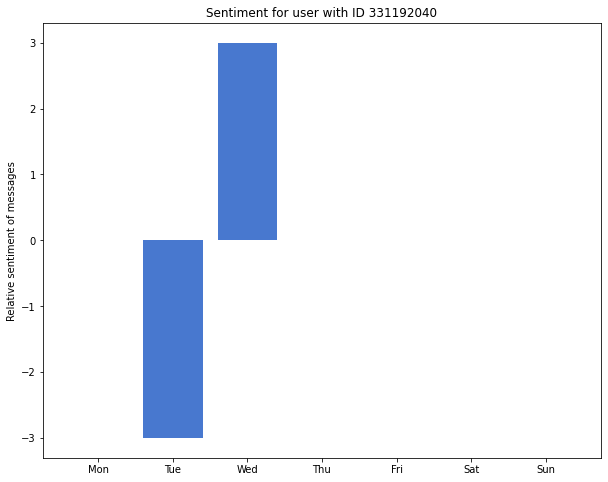

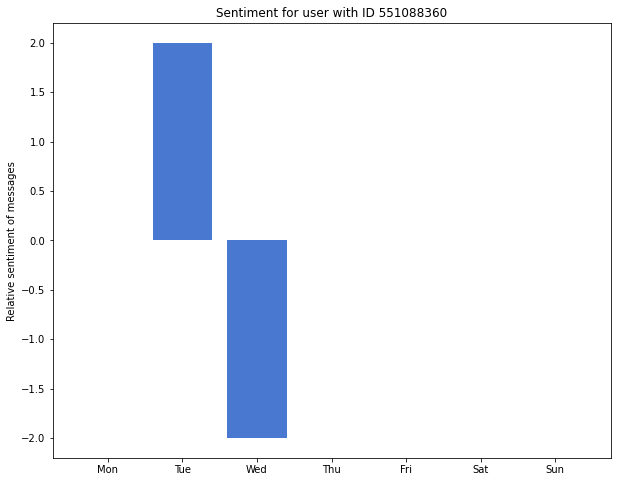

In [4]:
result = sentiment_text_analysis(data)
plot_sentiment_analysis_results(result)